In [ ]:
# Testing Kernel Connection

print("Kernel Connection Successfully ✅ ")

Kernel Connection Successfully ✅ 


Install Dependencies

In [2]:
# Install necessary libraries
! pip install tensorflow keras numpy pandas matplotlib scikit-learn opencv-python kaggle tqdm seaborn

Import Required Libraries

In [3]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

Define Dataset Paths (Assuming Dataset is already structured else run "restructure_dataset.py" file)

In [4]:
# Define the dataset path (No 'train' folder, directly using 'all' & 'hem')
BASE_DIR = "D:/FinalYearProject/Leukemia/LeukemiaCellClassification"
CATEGORIES = ["all", "hem"]

IMG_SIZE = 224  # Standard input size for CNNs
BATCH_SIZE = 32  # Optimal for training speed & stability

Load & Preprocess Data

In [ ]:
# Collect all image paths and labels
image_paths, labels = [], []

for category in CATEGORIES:
    category_path = os.path.join(BASE_DIR, category)
    for img in os.listdir(category_path):
        image_paths.append(os.path.join(category_path, img))
        labels.append(category)  # Label as 'all' or 'hem'

# Convert to DataFrame
df = pd.DataFrame({"filename": image_paths, "class": labels})

# Split into training and validation sets (Stratified)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    df["filename"], df["class"], test_size = 0.2, stratify = df["class"], random_state = 42
)

print(f"✅ Training Images: {len(train_paths)}")
print(f"✅ Validation Images: {len(val_paths)}")


✅ Training Images: 8528
✅ Validation Images: 2133


Display Sample Images

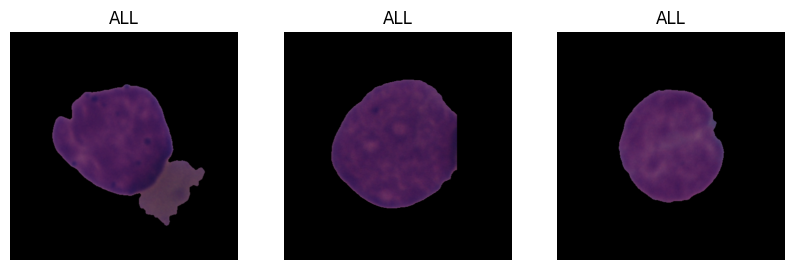

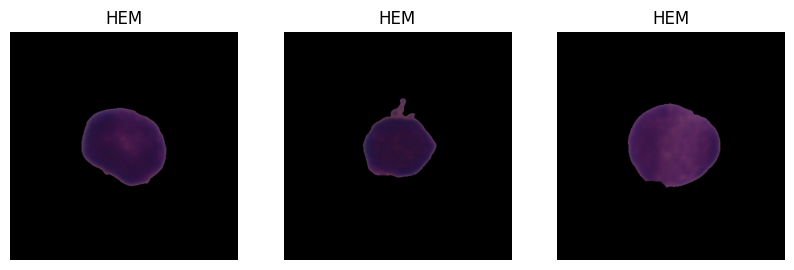

In [ ]:
def display_sample_images(category, num_images = 3):
    folder = os.path.join(BASE_DIR, category)
    images = random.sample(os.listdir(folder), num_images)

    plt.figure(figsize = (10, 5))
    for i, img_name in enumerate(images):
        img = cv2.imread(os.path.join(folder, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(category.upper())
        plt.axis("off")
    plt.show()

# Show images from both categories
display_sample_images("all")
display_sample_images("hem")


Create Image Data Generators

In [ ]:
# Apply image augmentation to improve generalization
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

val_datagen = ImageDataGenerator(rescale = 1./255)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe = pd.DataFrame({"filename": train_paths, "class": train_labels}),
    x_col = "filename",
    y_col = "class",
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = "binary"
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe = pd.DataFrame({"filename": val_paths, "class": val_labels}),
    x_col = "filename",
    y_col = "class",
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = "binary"
)

print("✅ Data Generators Ready")


Found 8528 validated image filenames belonging to 2 classes.
Found 2133 validated image filenames belonging to 2 classes.
✅ Data Generators Ready


Build CNN Model

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation = 'relu', input_shape = (IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation = 'relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.5),
    Dense(64, activation = 'relu'),
    Dropout(0.5),
    Dense(1, activation = 'sigmoid')  # Binary classification
])

model.compile(optimizer = Adam(learning_rate = 1e-4),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.summary()

d:\FinalYearProject\Leukemia\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,177,281 (42.64 MB)

 Trainable params: 11,177,281 (42.64 MB)

 Non-trainable params: 0 (0.00 B)

 Train Model with Callbacks

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3)

# Train model
history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 10,
    callbacks = [early_stopping, reduce_lr]
)

print("✅ Training Complete")


d:\FinalYearProject\Leukemia\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 573s 2s/step - accuracy: 0.6748 - loss: 0.6008 - val_accuracy: 0.6831 - val_loss: 0.5428 - learning_rate: 1.0000e-04
Epoch 2/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 437s 2s/step - accuracy: 0.7112 - loss: 0.5584 - val_accuracy: 0.7782 - val_loss: 0.5031 - learning_rate: 1.0000e-04
Epoch 3/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 447s 2s/step - accuracy: 0.7520 - loss: 0.5384 - val_accuracy: 0.7684 - val_loss: 0.4979 - learning_rate: 1.0000e-04
Epoch 4/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 453s 2s/step - accuracy: 0.7591 - loss: 0.5273 - val_accuracy: 0.8139 - val_loss: 0.4557 - learning_rate: 1.0000e-04
Epoch 5/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 408s 2s/step - accuracy: 0.7540 - loss: 0.5397 - val_accuracy: 0.7853 - val_loss: 0.4680 - learning_rate: 1.0000e-04
Epoch 6/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - accuracy: 0.7732 - loss: 0.5083 - val_accuracy: 0.8008 - val_loss: 0.4712 - learning_rate: 1.0000e-04
Epoch 7/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 421s 2s/step - acc

Evaluate Model

In [11]:
loss, accuracy = model.evaluate(val_generator)
print(f"✅ Model Accuracy: {accuracy * 100:.2f}%")

67/67 ━━━━━━━━━━━━━━━━━━━━ 56s 795ms/step - accuracy: 0.8258 - loss: 0.4202
✅ Model Accuracy: 82.75%


Visualize Training Performance

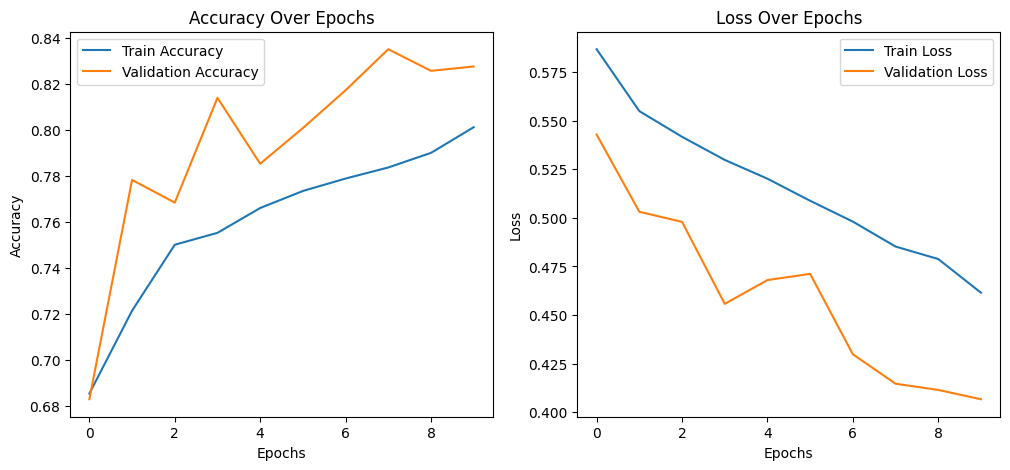

In [ ]:
# Plot accuracy and loss curves
plt.figure(figsize = (12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Over Epochs")

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Over Epochs")

plt.show()

Generate Classification Report & Confusion Matrix

67/67 ━━━━━━━━━━━━━━━━━━━━ 44s 615ms/step
✅ Classification Report:
               precision    recall  f1-score   support

         HEM       0.69      0.81      0.74      1455
         ALL       0.35      0.22      0.27       678

    accuracy                           0.62      2133
   macro avg       0.52      0.51      0.51      2133
weighted avg       0.58      0.62      0.59      2133



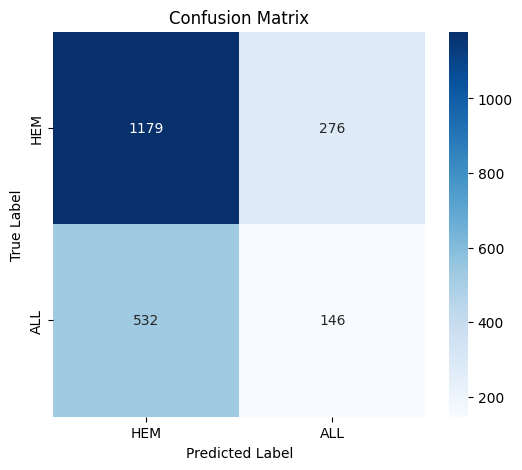

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get true labels and predicted labels
y_true = val_generator.classes
y_pred = (model.predict(val_generator) > 0.5).astype("int").flatten()

# Generate classification report
print("✅ Classification Report:\n", classification_report(y_true, y_pred, target_names = ["HEM", "ALL"]))

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize = (6, 5))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels = ["HEM", "ALL"], yticklabels = ["HEM", "ALL"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


Save Model with Custom Name

In [15]:
# Define custom filename
base_path = "D:/FinalYearProject/Leukemia/SavedModel/"

custom_model_name = "Leukemic-model-v3-82%-accuracy"

model_save_path = base_path + custom_model_name + ".h5"

# Save the model
model.save(model_save_path)

print(f"✅ Model saved successfully at: {model_save_path}")

✅ Model saved successfully at: D:/FinalYearProject/Leukemia/SavedModel/Leukemic-model-v3-82%-accuracy.h5
